## Load Dataset

In [2]:
!unzip -q agent_data.zip

In [ ]:
import pandas as pd

data = pd.read_csv("agent_data/data.csv")
data

,Image,question,answer
0,2085,What is the shape of the object that is furthe...,square
1,14958,Is the yellow object on the top or on the bottom?,bottom
2,11507,Is the red object on the left or on the right?,right
3,5798,Is the yellow object on the left or on the right?,right
4,1289,What is the shape of the blue object?,circle
...,...,...,...
95,13711,What is the color of the object that is closes...,red
96,16494,What is the color of the object that is closes...,gray
97,18117,What is the color of the object that is closes...,green
98,18342,What is the color of the object that is closes...,red


In [5]:
x = data['question'].to_list()
y = data['answer'].to_list()
image_list = data['Image'].to_list()

image_list = ['agent_data/images/'+str(i)+'.png' for i in image_list]

question: What is the shape of the object that is furthest from the gray object?
answer  : square


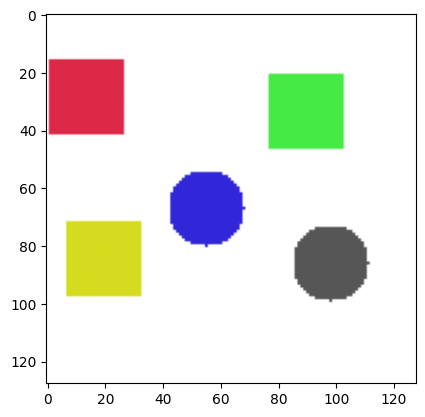

In [ ]:
import matplotlib.pyplot as plt

def show_data(i, x, y, image_list):
    print("question:", x[i])
    print("answer  :", y[i])
    image = plt.imread(image_list[i])
    plt.imshow(image), plt.show()

# Example usage with index 0
show_data(0, x, y, image_list)

## Load LVLM

In [7]:
!pip install qwen-vl-utils[decord]==0.0.8 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 39.5 MB/s eta 0:00:00


In [8]:
import torch
from PIL import Image
from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration
from qwen_vl_utils import process_vision_info


class QwenVLM:
    def __init__(self, model_name="Qwen/Qwen2.5-VL-3B-Instruct", device="cuda"):
        # Load the model
        self.model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
            model_name,
            torch_dtype="auto",
            device_map="auto"
        )

        # Load the processor
        self.processor = AutoProcessor.from_pretrained(model_name)

        # Set device
        self.device = device

    def inference(self, prompt="Describe this image.", image_path=None, max_new_tokens=128):
        if image_path:
            # Load image from local path
            image = Image.open(image_path).convert("RGB")

            # Construct messages in chat format with image
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image", "image": image},
                        {"type": "text", "text": prompt},
                    ],
                }
            ]

            # Prepare text input
            text = self.processor.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )

            # Prepare image/video inputs
            image_inputs, video_inputs = process_vision_info(messages)

            # Tokenize inputs
            inputs = self.processor(
                text=[text],
                images=image_inputs,
                videos=video_inputs,
                padding=True,
                return_tensors="pt",
            ).to(self.device)

        else:
            # Text-only mode
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                    ],
                }
            ]

            text = self.processor.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )

            inputs = self.processor(
                text=[text],
                padding=True,
                return_tensors="pt",
            ).to(self.device)

        # Generate output
        generated_ids = self.model.generate(**inputs, max_new_tokens=max_new_tokens)
        generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]

        # Decode output
        output_text = self.processor.batch_decode(
            generated_ids_trimmed,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False,
        )
        return output_text

vlm = QwenVLM()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/5.70k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

### Example

In [9]:
vlm.inference(image_path=image_list[0])

['The image contains five colored shapes arranged in a row from left to right:\n\n1. A red square.\n2. A green rectangle.\n3. A yellow triangle.\n4. A blue circle.\n5. A black dot.\n\nThese shapes are simple geometric figures with different colors and orientations.']

## LLM as a judge

In [ ]:
judge_prompt = """
You are an expert evaluator.

Given a question, a model's answer, and a ground truth answer, your task is to determine whether the model's answer logically implies the ground truth answer.

Definitions:
- "Implies" means that the model's answer guarantees or entails the ground truth. Minor wording differences are acceptable if the meaning is preserved.
- Do not be lenient: only respond "Yes" if the implication is clear and unambiguous.

Question:
{question}

Model's Answer:
{text1}

Ground Truth Answer:
{text2}

Does the model's answer imply the ground truth answer? Respond with exactly "Yes" or "No".
"""

def judge(vlm, question, text1, text2):
    prompt = judge_prompt.format(question=question, text1=text1, text2=text2)
    response = vlm.inference(prompt)[0].strip().lower()
    return 1 if response.startswith("yes") else 0

### Example

In [11]:

judge(vlm, "what is the shape of object?","square", "I think shape of object is square")


1

In [12]:
# In this part should check the evalution procedure with negative examples
judge(vlm, "what is the shape of object?", "square", "the object is blue")


0

## zero-shot

```markdown
**Guideline:** Implement the zero-shot evaluation loop:
1. For each index `i` in the dataset:
   - Use `vlm.inference(image_path=image_list[i], prompt=x[i])` to get the model's prediction.
   - Store the prediction in `pred`.
   - Call `judge(vlm, x[i], pred[-1], y[i])` to obtain a binary assessment of correctness.
   - Append the judge's result to `true_pred`.
2. Use `tqdm` to monitor progress.
```

In [ ]:
from tqdm.notebook import tqdm

pred = []
true_pred = []

# This should be implemented by the students
for i in tqdm(range(len(x))):
    model_output = vlm.inference(image_path=image_list[i], prompt=x[i])
    answer = model_output[-1]  # Take the last sentence/response
    print(f"{i:2d} >", model_output)

    pred.append(answer)
    judgement = judge(vlm, x[i], answer, y[i])
    true_pred.append(judgement)

acc_baseline = sum(true_pred) / len(true_pred)

  0%|          | 0/100 [00:00<?, ?it/s]

 0 > ['The object that is furthest from the gray object is the red square.']
 1 > ['The yellow object is on the bottom.']
 2 > ['The red object is on the right.']
 3 > ['The yellow object is on the left.']
 4 > ['The blue object in the image is a circle.']
 5 > ['The object that is furthest from the green object is the blue circle.']
 6 > ['The object that is furthest from the red object is the blue square.']
 7 > ['The blue object is on the left.']
 8 > ['The yellow object is on the bottom.']
 9 > ['The object that is closest to the gray object is red.']
10 > ['The object that is closest to the green object is blue.']
11 > ['The object that is closest to the yellow object is red.']
12 > ['The object that is closest to the red object is yellow.']
13 > ['The object that is furthest from the red object is the green circle.']
14 > ['The red object is on the bottom.']
15 > ['The object that is furthest from the gray object is the yellow square.']
16 > ['The object that is closest to the re

In [1]:
# Calculate the total accuracy
print(f"Accuracy: {acc_baseline:.2f}")

Accuracy: 0.64


## Build your own agent

### Classic agents

In [ ]:
import cv2
import numpy as np
from typing import List, Tuple
from tqdm.notebook import tqdm


def query_vlm(prompt: str, image_path: str) -> str:
    return vlm.inference(image_path=image_path, prompt=prompt)


def agent1(prompt: str, image_path: str) -> Tuple[str, str]:
    """Categorize questions into specific types for targeted processing"""
    q = prompt.lower()
    if any(x in q for x in ["what color", "color of", "which color"]):
        prompt_type = "color"
    elif any(x in q for x in ["what shape", "shape of", "which shape"]):
        prompt_type = "shape"
    elif any(x in q for x in ["how many", "count the", "number of"]):
        prompt_type = "count"
    elif any(x in q for x in ["where is", "located", "position of"]):
        prompt_type = "spatial"
    elif q.startswith("is there") or q.startswith("does the") or q.startswith("are there"):
        prompt_type = "existence"
    elif "text" in q or "word" in q or "letter" in q:
        prompt_type = "text"
    else:
        prompt_type = "general"

    return f"[Question Type: {prompt_type}]\n{prompt}", image_path


def agent2(prompt: str, image_path: str) -> Tuple[str, str]:
    """Detect dominant colors using HSV color space and clustering"""
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Mask for non-black/non-white regions
    lower_bound = np.array([0, 50, 50])
    upper_bound = np.array([180, 255, 255])
    mask = cv2.inRange(hsv, lower_bound, upper_bound)
    masked = cv2.bitwise_and(image, image, mask=mask)

    # Find dominant colors using k-means
    pixels = masked.reshape(-1, 3)
    pixels = pixels[np.all(pixels != 0, axis=1)]  # Remove black pixels

    if len(pixels) == 0:
        return "No significant colors detected"

    k = 3
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(
        pixels.astype(np.float32), k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS
    )

    # Convert to HSV for better color naming
    centers_hsv = cv2.cvtColor(np.array([centers], dtype=np.uint8), cv2.COLOR_BGR2HSV)[0]

    # Name the colors
    color_names = []
    for hsv_val in centers_hsv:
        h, s, v = hsv_val
        if s < 50 or v < 50:
            continue  # Skip desaturated/dark colors

        if h < 15:
            color_names.append("red")
        elif h < 35:
            color_names.append("orange")
        elif h < 70:
            color_names.append("yellow")
        elif h < 85:
            color_names.append("green")
        elif h < 130:
            color_names.append("blue")
        elif h < 170:
            color_names.append("purple")
        else:
            color_names.append("red")

    return f"Dominant colors: {', '.join(set(color_names))}\n{prompt}", image_path


def agent3(prompt: str, image_path: str) -> Tuple[str, str]:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = set()
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)
        if len(approx) == 3:
            shapes.add("triangle")
        elif len(approx) == 4:
            shapes.add("square" if cv2.isContourConvex(approx) else "quadrilateral")
        elif len(approx) > 4:
            shapes.add("circle")

    return f"[Detected Shapes: {', '.join(shapes)}]\n{prompt}", image_path


def generate_prompt(prompt: str, image_path: str, agents_list = []) -> Tuple[str, str]:
    for agent in agents_list:
        prompt, image_path = agent(prompt, image_path)
    return prompt, image_path


# Verifier
verify_prompt = """
Analyze the following question and response for consistency and correctness:

Question: {question}
Response: {response}

Is the response relevant and correct? Reply with Yes or No.
"""
def verify_response(prompt: str, image_path: str, response: str) -> bool:
    result = vlm.inference(verify_prompt.format(question=prompt, response=response))[0].strip()
    return result.startswith("yes")


# Agent Loop with Verifier
def agent_loop(question: str, image_path: str, agents_list, max_retries=1):
    retries = 0
    while retries < max_retries:
        prompt, image_path = generate_prompt(question, image_path, agents_list)
        response = query_vlm(prompt, image_path)
        if verify_response(question, image_path, response):
            return response
        retries += 1
    return response


def run_agent_loop(agents_list, max_retries=1, verbose=0):
    pred = []
    true_pred = []
    if verbose>0: bar = tqdm(total=len(x))

    for i in range(len(x)):
        res = agent_loop(
            image_path=image_list[i],
            question=x[i],
            agents_list=agents_list,
            max_retries=max_retries
        )
        pred.append(res)

        if verbose>1: print(f"{i:2d} >", res)

        true_pred.append(judge(vlm, x[i], pred[-1], y[i]))
        if verbose: bar.update(1)

    if verbose>0:
        bar.close()
        del bar
    accuracy = sum(true_pred) / len(true_pred)
    return accuracy


acc_123 = run_agent_loop([agent1, agent2, agent3], verbose=2)

  0%|          | 0/100 [00:00<?, ?it/s]

 0 > ['The shape of the object that is furthest from the gray object is a square.']
 1 > ['The yellow object is on the bottom.']
 2 > ['The red object is on the right.']
 3 > ['The yellow object is on the left.']
 4 > ['The shape of the blue object is a circle.']
 5 > ['The shape of the object that is furthest from the green object is a square.']
 6 > ['The shape of the object that is furthest from the red object is a square.']
 7 > ['The blue object is on the left.']
 8 > ['The yellow object is on the bottom.']
 9 > ['The color of the object that is closest to the gray object is red.']
10 > ['The object that is closest to the green object is blue.']
11 > ['The color of the object that is closest to the yellow object is red.']
12 > ['The object that is closest to the red object is blue.']
13 > ['The shape of the object that is furthest from the red object is a square.']
14 > ['The red object is on the bottom.']
15 > ['The shape of the object that is furthest from the gray object is a s

In [ ]:
# Calculate the total accuracy
print(f"Accuracy: {acc_123:.2f}")

Accuracy: 0.65


### Ablation Study

```markdown
In this part, you need to test the impact of each agent by removing them one by one to assess how much each contributes to the system’s accuracy. Your goal is to optimize the system and identify the most effective configuration. You should also include a written analysis explaining the role of each agent and justify why it's necessary based on its performance.
```

In [ ]:
# Remove each agent one by one
acc_12 = run_agent_loop([agent1, agent2], verbose=1)
acc_13 = run_agent_loop([agent1, agent3], verbose=1)
acc_23 = run_agent_loop([agent2, agent3], verbose=1)

# Test agents individually
acc_1 = run_agent_loop([agent1], verbose=1)
acc_2 = run_agent_loop([agent2], verbose=1)
acc_3 = run_agent_loop([agent3], verbose=1)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

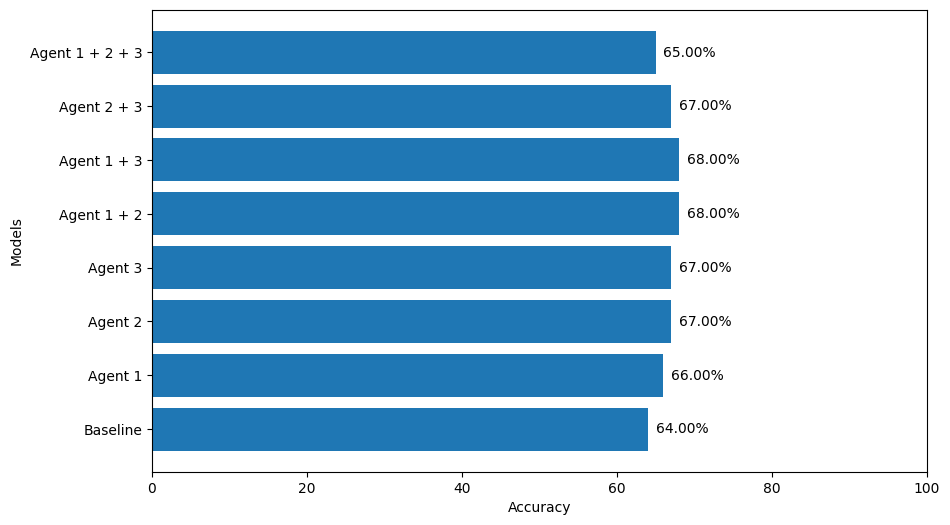

In [ ]:
accuracies = [
    acc_baseline,
    acc_1,
    acc_2,
    acc_3,
    acc_12,
    acc_13,
    acc_23,
    acc_123
]
model_names = [
    'Baseline',
    'Agent 1',
    'Agent 2',
    'Agent 3',
    'Agent 1 + 2',
    'Agent 1 + 3',
    'Agent 2 + 3',
    'Agent 1 + 2 + 3',
]

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(model_names, [a*100 for a in accuracies])
for bar in bars:
    width = bar.get_width()
    plt.text(width+1, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}%", va='center')
plt.xlim(0, 100)
plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.show()


<br><br><br><br>

### note:
<hr>


<br>


<p><b><font color="orange">

For the next two parts, we use only 25 samples to compute the `accuracy` of the LLM agent,
  as it takes too long to run and Google Colab terminates the session during execution.

</font></b></p>

<br>
<hr>
<br><br><br><br>


### DL Agents

In [ ]:
import numpy as np
from typing import List, Tuple


def query_vlm(prompt: str, image_path: str) -> str:
    return vlm.inference(image_path=image_path, prompt=prompt)


def agent1(prompt: str, image_path: str) -> Tuple[str, str]:
    """Enhanced Question Analysis Agent with DL-supported reasoning"""

    # First-stage reasoning about question type and requirements
    intermediate_prompt = f"""
    Analyze the question deeply: '{prompt}'
    1. Identify the question type (categorization, existence, counting, etc.)
    2. Propose analysis steps needed
    Provide concise reasoning for each point.
    """
    intermediate = query_vlm(intermediate_prompt, image_path)

     # Generate analysis plan using intermediate reasoning
    final_prompt = f"""
    Based on this analysis:
    {intermediate}

    Generate a detailed processing plan to answer the question.
    """
    final = query_vlm(final_prompt, image_path)
    return intermediate, final


def agent2(prompt: str, image_path: str) -> Tuple[str, str]:
    """Visual Grounding Agent with DL feature extraction"""
    # Extract visual features relevant to the prompt
    intermediate_prompt = f"""
    Based on the image and this question: '{prompt}',
    Identify key visual elements to focus on. Provide this as a step-by-step analysis.
    """
    intermediate = query_vlm(intermediate_prompt, image_path)

    # Generate visual grounding instructions
    final_prompt = f"""
    Using this visual analysis:
    {intermediate}

    Answer the question accurately.
    """
    final = query_vlm(final_prompt, image_path)
    return intermediate, final


def agent3(prompt: str, image_path: str) -> Tuple[str, str]:
    intermediate_prompt = f"""
    Analyze spatial relations or attributes related to:
    {prompt}

    Provide intermediate spatial reasoning.
    """
    intermediate = query_vlm(intermediate_prompt, image_path)

    final_prompt = f"""
    Using this spatial analysis:
    {intermediate}

    Answer the question accurately.
    """
    final = query_vlm(final_prompt, image_path)
    return intermediate, final


def generate_prompt(prompt: str, image_path: str, agents_list) -> Tuple[str, str]:
    for agent in agents_list:
        _, prompt = agent(prompt, image_path)
    return prompt, image_path


# Verifier
verify_prompt = """
Analyze the following question and response for consistency and correctness:

Question: {question}
Response: {response}

Is the response relevant and correct? Reply with Yes or No.
"""
def verify_response(prompt: str, image_path: str, response: str) -> bool:
    result = vlm.inference(verify_prompt.format(question=prompt, response=response))[0].strip()
    return result.startswith("yes")


# Agent Loop with Verifier
def agent_loop(question: str, image_path: str, agents_list, max_retries=1):
    retries = 0
    while retries < max_retries:
        prompt, image_path = generate_prompt(question, image_path, agents_list)
        response = query_vlm(prompt, image_path)
        if verify_response(question, image_path, response):
            return response
        retries += 1
    return response


def run_agent_loop(agents_list, max_retries=1, verbose=0, max_test=1000):
    pred = []
    true_pred = []
    if verbose>0: bar = tqdm(total= min(max_test, len(x)))

    for i in range(min(max_test, len(x))):
        res = agent_loop(
            image_path=image_list[i],
            question=x[i],
            agents_list=agents_list,
            max_retries=max_retries
        )
        pred.append(res)

        if verbose>1: print(f"{i:2d} >", res)

        true_pred.append(judge(vlm, x[i], pred[-1], y[i]))
        if verbose: bar.update(1)

    if verbose>0:
        bar.close()
        del bar
    accuracy = sum(true_pred) / len(true_pred)
    return accuracy



acc_123 = run_agent_loop([agent1, agent2, agent3], verbose=2, max_test=25)

  0%|          | 0/25 [00:00<?, ?it/s]

 0 > ['The object that is furthest from the gray circle is the green square.']
 1 > ['Correct. The yellow square is located at the bottom of the image, directly beneath the black square.']
 2 > ['Correct. The red object is located in the top-right corner of the image, which means it is indeed on the right side of the image.']
 3 > ['Correct! The yellow circle is indeed on the right side of the blue square in the image.']
 4 > ['The shapes of the objects are as follows:\n\n- Red Circle: Circular\n- Gray Square: Square\n- Green Circle: Circular\n- Blue Dot: Circular (with zero radius)\n- Yellow Rectangle: Rectangular\n\nThere are no additional spatial relations or attributes to analyze further based on the given information.']
 5 > ['Understood. The red object is indeed located at the bottom-center of the image.']
 6 > ["I see you've provided an image with four shapes: a blue square, a yellow square, a red circle, and a green triangle. The instruction mentions that the green triangle is 

In [ ]:
# Calculate the total accuracy
print(f"Accuracy: {acc_123:.2f}")

Accuracy: 0.28


### Ablation Study

```markdown
In this part, you need to test the impact of each agent by removing them one by one to assess how much each contributes to the system’s accuracy. Your goal is to optimize the system and identify the most effective configuration. You should also include a written analysis explaining the role of each agent and justify why it's necessary based on its performance
```

In [ ]:
# Remove each agent one by one
acc_12 = run_agent_loop([agent1, agent2], verbose=1, max_test=25)
acc_13 = run_agent_loop([agent1, agent3], verbose=1, max_test=25)
acc_23 = run_agent_loop([agent2, agent3], verbose=1, max_test=25)

# Test agents individually
acc_1 = run_agent_loop([agent1], verbose=1, max_test=25)
acc_2 = run_agent_loop([agent2], verbose=1, max_test=25)
acc_3 = run_agent_loop([agent3], verbose=1, max_test=25)

# Test no-agents
acc_baseline = run_agent_loop([ ], verbose=1, max_test=25)

  0%|          | 0/25 [00:00<?, ?it/s]



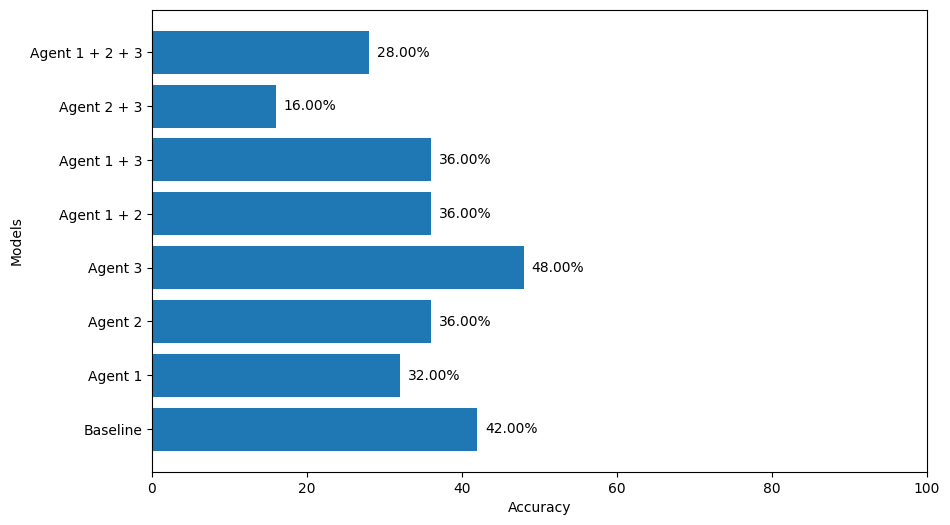

In [18]:
accuracies = [
    acc_baseline,
    acc_1,
    acc_2,
    acc_3,
    acc_12,
    acc_13,
    acc_23,
    acc_123
]
model_names = [
    'Baseline',
    'Agent 1',
    'Agent 2',
    'Agent 3',
    'Agent 1 + 2',
    'Agent 1 + 3',
    'Agent 2 + 3',
    'Agent 1 + 2 + 3',
]

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(model_names, [a*100 for a in accuracies])
for bar in bars:
    width = bar.get_width()
    plt.text(width+1, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}%", va='center')
plt.xlim(0, 100)
plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.show()